In [ ]:
!pip install transformers

In [78]:
TRAIN_SIZE = 8000
TEST_SIZE = 2717
MAX_SEN_LEN = 128
BATCH_SIZE = 16
DROPOUT = 0.1
LEARNING_RATE = 2e-5
NUM_EPOCH = 5
EMB_SIZE = 768

In [ ]:
relation = ['Other',
            'Message-Topic(e1,e2)',
            'Message-Topic(e2,e1)',
            'Product-Producer(e1,e2)',
            'Product-Producer(e2,e1)',
            'Instrument-Agency(e1,e2)',
            'Instrument-Agency(e2,e1)',
            'Entity-Destination(e1,e2)',
            'Entity-Destination(e2,e1)',
            'Cause-Effect(e1,e2)',
            'Cause-Effect(e2,e1)',
            'Component-Whole(e1,e2)',
            'Component-Whole(e2,e1)',
            'Entity-Origin(e1,e2)',
            'Entity-Origin(e2,e1)',
            'Member-Collection(e1,e2)',
            'Member-Collection(e2,e1)',
            'Content-Container(e1,e2)',
            'Content-Container(e2,e1)']

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
import pickle
import numpy as np

In [ ]:
ADDITIONAL_SPECIAL_TOKENS = ["<e1>", "</e1>", "<e2>", "</e2>"]
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer.add_special_tokens({"additional_special_tokens": ADDITIONAL_SPECIAL_TOKENS})

4

In [ ]:
START_E1 = tokenizer.encode('<e1>')[1]
END_E1 = tokenizer.encode('</e1>')[1]
START_E2 = tokenizer.encode('<e2>')[1]
END_E2 = tokenizer.encode('</e2>')[1]

In [ ]:
def seperate_file(fi_path, fo1_path, fo2_path, fo3_path, size):
  fi = open(fi_path,'r')
  fo1 = open(fo1_path,'w')
  fo2 = open(fo2_path,'w')
  fo3 = open(fo3_path,'w')
  for i in range(size):
    l1 = fi.readline()
    l2 = fi.readline()
    l3 = fi.readline()
    l4 = fi.readline()
    l1 = l1.strip().split()
    l1 = l1[1:]
    l1[0] = l1[0][1:]
    l1[len(l1)-1] = l1[len(l1)-1][:-1]
    l1 = ' '.join(l1)
    fo1.write(l1)
    fo1.write('\n')
    l1 = l1.replace('<e1>', '')
    l1 = l1.replace('</e1>', '')
    l1 = l1.replace('<e2>', '')
    l1 = l1.replace('</e2>', '')
    fo2.write(l1)
    fo2.write('\n')
    for j in range(len(relation)):
      if relation[j] in l2:
        fo3.write(str(j))
        fo3.write('\n')

In [ ]:
seperate_file('TRAIN_FILE.TXT', 'train_x_ref.txt', 'train_x.txt', 'train_y.txt', TRAIN_SIZE)

In [ ]:
seperate_file('TEST_FILE_FULL.TXT', 'test_x_ref.txt', 'test_x.txt', 'test_y.txt', TEST_SIZE)

In [ ]:
def make_token_pickle(filein, fileout):
  fi = open(filein,'r')
  fo = open(fileout, 'wb')
  x = fi.readlines()
  for s in x:
    token_ids = tokenizer.encode(s)
    pickle.dump(token_ids, fo)

In [ ]:
make_token_pickle('train_x.txt', 'train_x_tok_ids')

In [ ]:
make_token_pickle('test_x.txt', 'test_x_tok_ids')

In [ ]:
def load_token_pickle(filein, size):
  fi = open(filein,'rb')
  x = []
  for i in range(size):
    s = pickle.load(fi)
    x.append(s)
  return x

In [ ]:
train_x = load_token_pickle('train_x_tok_ids', TRAIN_SIZE)

In [ ]:
test_x = load_token_pickle('test_x_tok_ids', TEST_SIZE)

In [ ]:
def lengthen_token_seq(a):
  for s in a:
    while len(s) < MAX_SEN_LEN:
      s.append(0)

In [ ]:
lengthen_token_seq(train_x)

In [ ]:
lengthen_token_seq(test_x)

In [ ]:
train_x = tf.constant(train_x)

In [ ]:
test_x = tf.constant(test_x)

In [ ]:
def make_pos_pickle(filein, fileout):
  fi = open(filein,'r')
  fo = open(fileout, 'wb')
  x = fi.readlines()
  x_pos = []
  for s in x:
    token_ids = tokenizer.encode(s)
    pos = []
    for i in range(len(token_ids)):
      if token_ids[i] == START_E1:
        pos.append(i)
      if token_ids[i] == END_E1:
        pos.append(i)
      if token_ids[i] == START_E2:
        pos.append(i)
      if token_ids[i] == END_E2:
        pos.append(i)
    x_pos.append(pos)
  pickle.dump(x_pos, fo)

In [ ]:
make_pos_pickle('train_x_ref.txt', 'train_x_pos')

In [ ]:
make_pos_pickle('test_x_ref.txt', 'test_x_pos')

In [ ]:
fi = open('train_x_pos','rb')
train_x_pos = pickle.load(fi)

In [ ]:
fi = open('test_x_pos','rb')
test_x_pos = pickle.load(fi)

In [ ]:
def make_head_e1_e2_pickle(a, out0, out1, out2):
  head_mask = []
  en1_mask = []
  en2_mask = []
  fo0 = open(out0, 'wb')
  fo1 = open(out1, 'wb')
  fo2 = open(out2, 'wb')
  for t in a:
    m0 = []
    for i in range(MAX_SEN_LEN):
      m0.append(0.0)
    m0[0] = 1.0
    head_mask.append(m0)
    m1 = []
    for i in range(MAX_SEN_LEN):
      m1.append(0.0)
    for i in range(t[0], t[1]-1):
      m1[i] = 1/(t[1]-1 - t[0])
    en1_mask.append(m1)
    m2 = []
    for i in range(MAX_SEN_LEN):
      m2.append(0.0)
    for i in range(t[2]-2, t[3]-3):
      m2[i] = 1/((t[3]-3) - (t[2]-2))
    en2_mask.append(m2)
  pickle.dump(head_mask, fo0)
  pickle.dump(en1_mask, fo1)
  pickle.dump(en2_mask, fo2)

In [ ]:
make_head_e1_e2_pickle(train_x_pos, 'train_x_head_mask', 'train_x_e1_mask', 'train_x_e2_mask')

In [ ]:
make_head_e1_e2_pickle(test_x_pos, 'test_x_head_mask', 'test_x_e1_mask', 'test_x_e2_mask')

In [ ]:
fi = open('train_x_head_mask', 'rb')
train_x_head_mask = pickle.load(fi)

In [ ]:
fi = open('test_x_head_mask', 'rb')
test_x_head_mask = pickle.load(fi)

In [ ]:
train_x_head_mask = tf.constant(train_x_head_mask)

In [ ]:
test_x_head_mask = tf.constant(test_x_head_mask)

In [ ]:
fi = open('train_x_e1_mask', 'rb')
train_x_e1_mask = pickle.load(fi)

In [ ]:
fi = open('test_x_e1_mask', 'rb')
test_x_e1_mask = pickle.load(fi)

In [ ]:
train_x_e1_mask = tf.constant(train_x_e1_mask)

In [ ]:
test_x_e1_mask = tf.constant(test_x_e1_mask)

In [ ]:
fi = open('train_x_e2_mask', 'rb')
train_x_e2_mask = pickle.load(fi)

In [ ]:
fi = open('test_x_e2_mask', 'rb')
test_x_e2_mask = pickle.load(fi)

In [ ]:
train_x_e2_mask = tf.constant(train_x_e2_mask)

In [ ]:
test_x_e2_mask = tf.constant(test_x_e2_mask)

In [ ]:
fi = open('train_y.txt', 'r')
train_y = []
for l in fi:
  l = int(l.strip())
  train_y.append(l)

In [ ]:
train_y = tf.keras.utils.to_categorical(train_y)

In [ ]:
def mat_mul(hidden_output, e_mask):
  e_mask = tf.expand_dims(e_mask, 1)
  e_mask = tf.cast(e_mask, tf.float32)
  prod = e_mask @ hidden_output
  prod = tf.squeeze(prod, axis=1)
  return prod

In [ ]:
encoder = TFBertModel.from_pretrained("bert-base-uncased")

input_ids = tf.keras.layers.Input(shape=(MAX_SEN_LEN,), dtype='int32')
head_mask = tf.keras.layers.Input(shape=(MAX_SEN_LEN,))
e1_mask = tf.keras.layers.Input(shape=(MAX_SEN_LEN,))
e2_mask = tf.keras.layers.Input(shape=(MAX_SEN_LEN,))

bertoutput = encoder(input_ids)
emb = bertoutput[0]

cls = mat_mul(emb, head_mask)
cls = tf.keras.layers.Dropout(DROPOUT)(cls)
cls = tf.keras.layers.Dense(EMB_SIZE, activation='tanh')(cls)
# cls = tf.keras.layers.Dense(EMB_SIZE, activation='relu')(cls)

e1 = mat_mul(emb, e1_mask)
e1 = tf.keras.layers.Dropout(DROPOUT)(e1)
e1 = tf.keras.layers.Dense(EMB_SIZE, activation='tanh')(e1)
# e1 = tf.keras.layers.Dense(EMB_SIZE, activation='relu')(e1)

e2 = mat_mul(emb, e2_mask)
e2 = tf.keras.layers.Dropout(DROPOUT)(e2)
e2 = tf.keras.layers.Dense(EMB_SIZE, activation='tanh')(e2)
# e2 = tf.keras.layers.Dense(EMB_SIZE, activation='relu')(e2)

com = tf.keras.layers.concatenate([cls, e1, e2])
# com = tf.keras.layers.concatenate([e1, e2])

out = tf.keras.layers.Dropout(DROPOUT)(com)
# out = tf.keras.layers.Dropout(DROPOUT)(cls)
out = tf.keras.layers.Dense(len(relation), activation='softmax')(out)

model = tf.keras.Model(inputs=[input_ids, head_mask, e1_mask, e2_mask], outputs=out)
# model = tf.keras.Model(inputs=[input_ids, head_mask], outputs=out)
# model = tf.keras.Model(inputs=[input_ids, e1_mask, e2_mask], outputs=out)
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics='accuracy')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 128)]        0                                            
______________________________________________________________________________________________

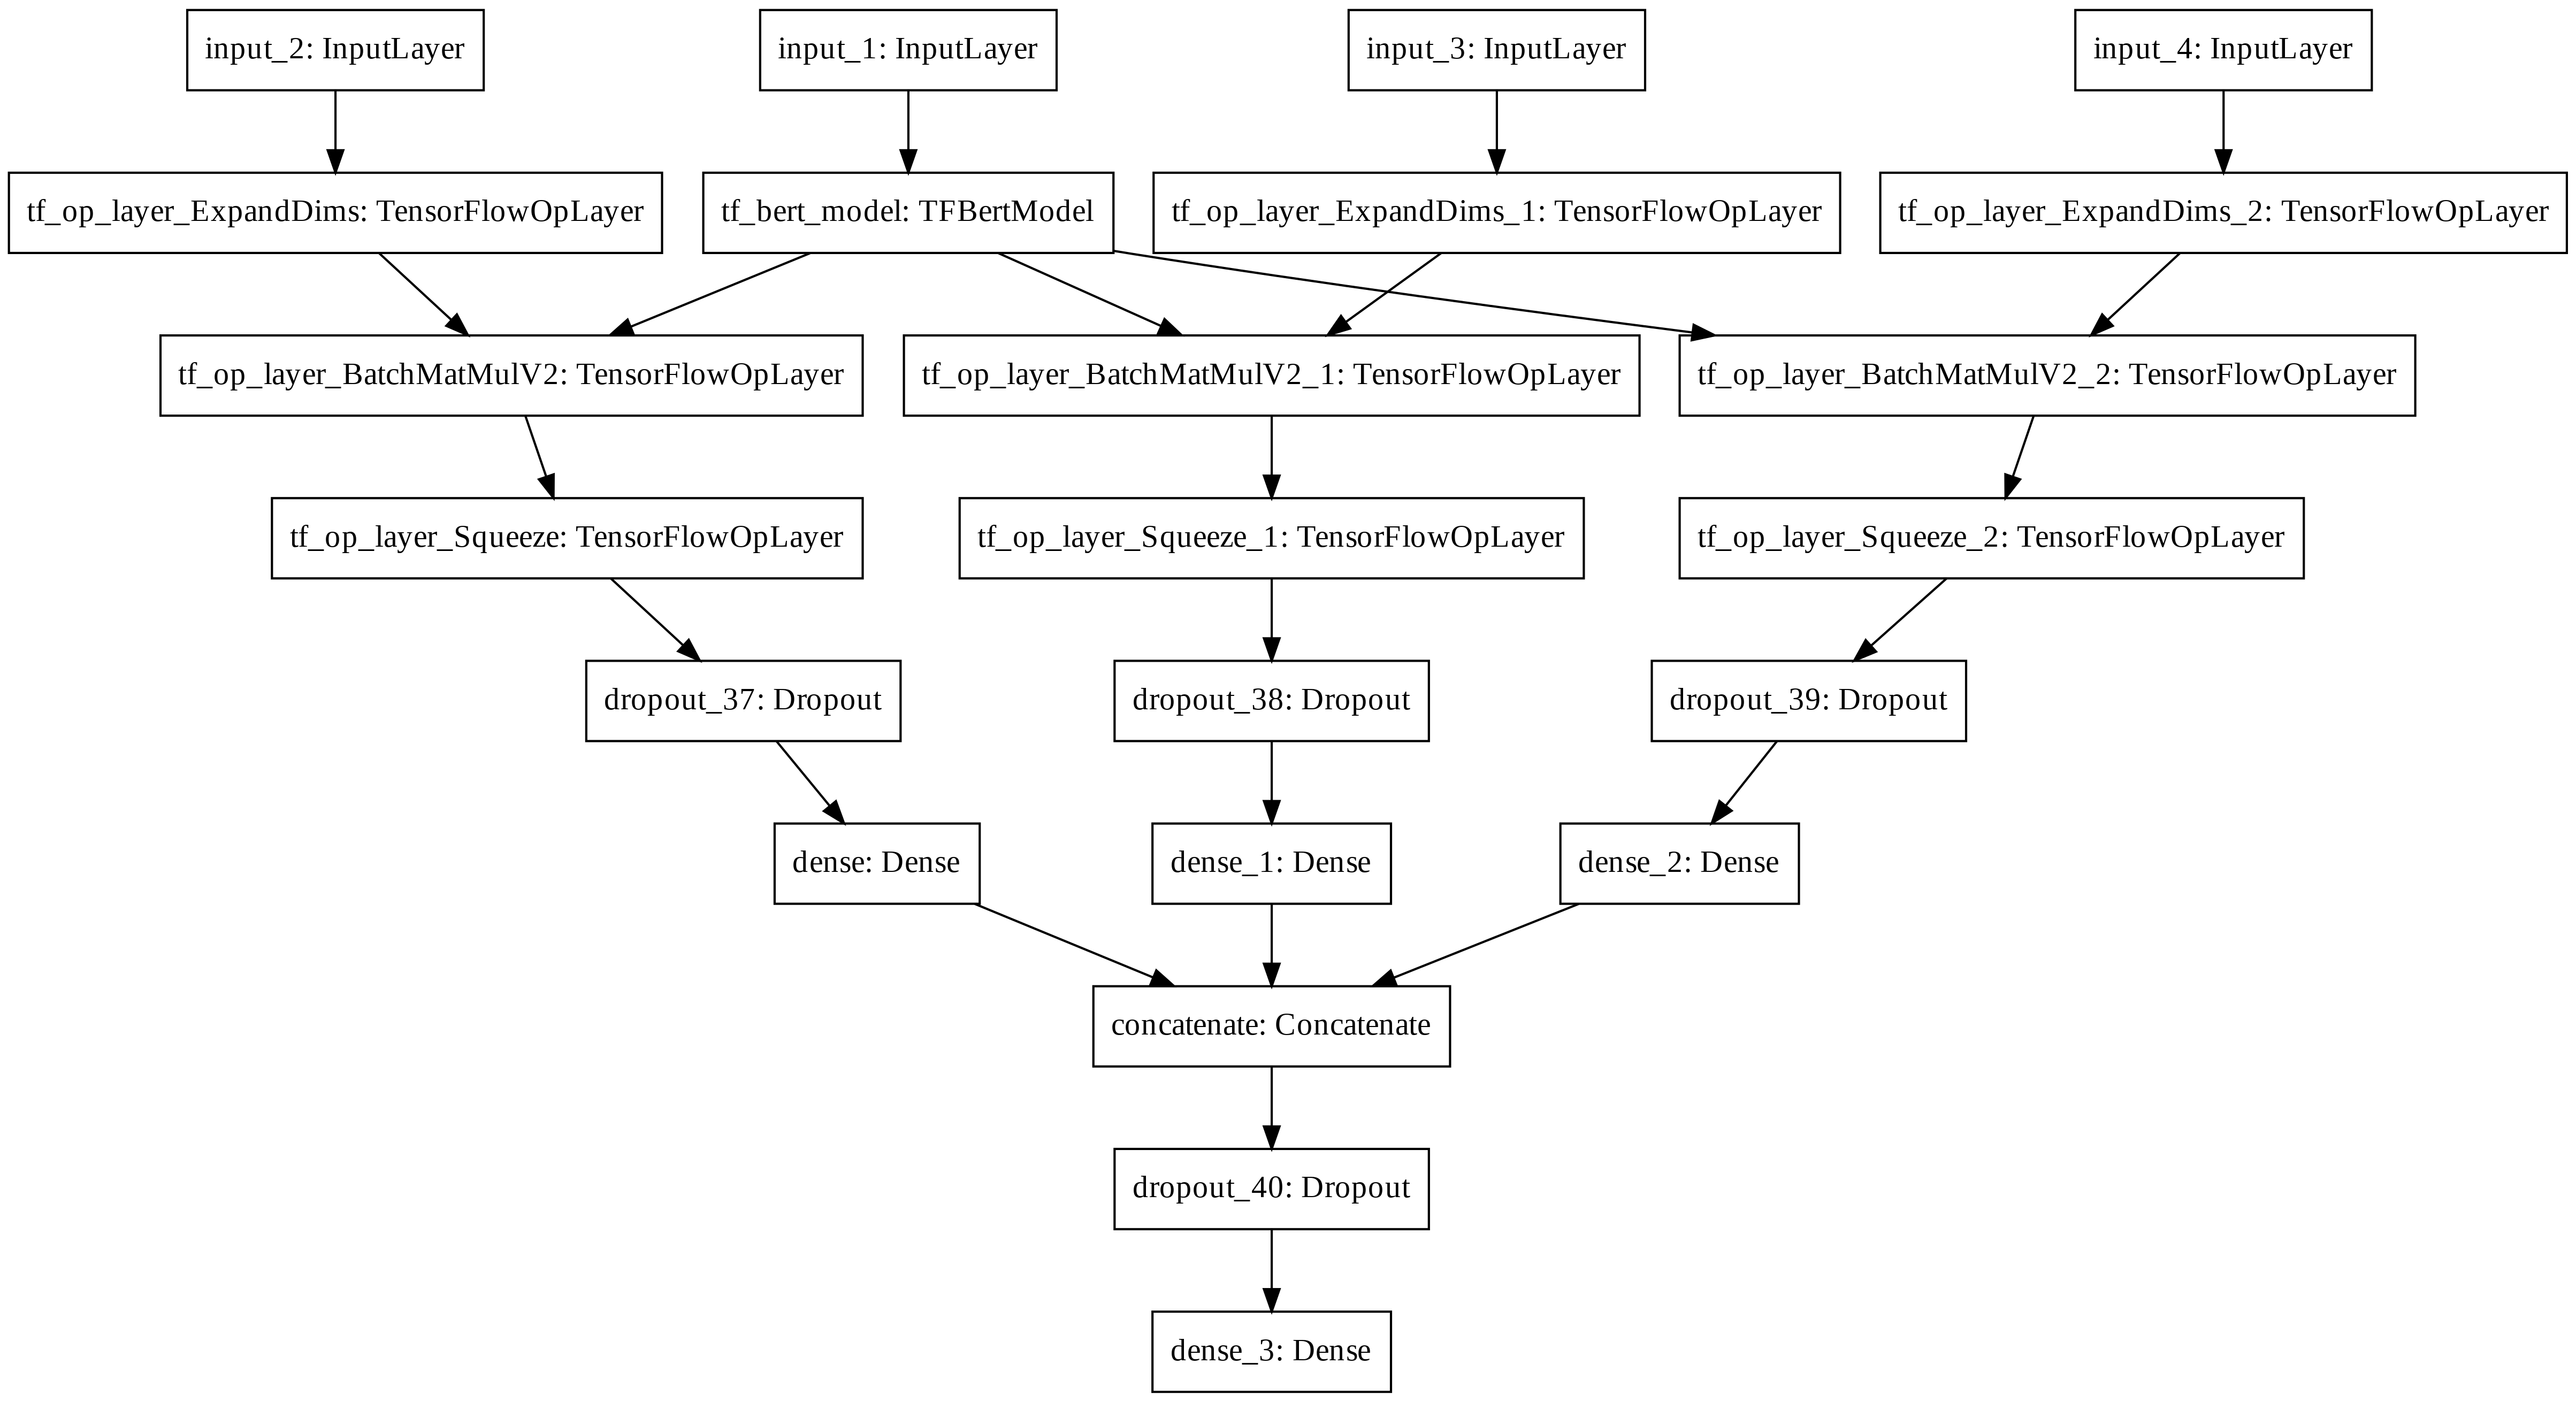

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=300)

In [ ]:
model.fit([train_x, train_x_head_mask, train_x_e1_mask, train_x_e2_mask], train_y, batch_size=BATCH_SIZE, epochs=NUM_EPOCH)
# model.fit([train_x, train_x_head_mask], train_y, batch_size=BATCH_SIZE, epochs=NUM_EPOCH)
# model.fit([train_x, train_x_e1_mask, train_x_e2_mask], train_y, batch_size=BATCH_SIZE, epochs=NUM_EPOCH)

In [ ]:
model.save_weights('./my_checkpoint/ckpt')

In [ ]:
model.load_weights('./my_checkpoint/ckpt')

In [ ]:
pred = model.predict([test_x, test_x_head_mask, test_x_e1_mask, test_x_e2_mask])

In [ ]:
for j in range(2):
  fo = open('proposed_answers.txt', 'w')
  for i in range(len(pred)):
    fo.write(str(8001+i))
    fo.write('\t')
    fo.write(relation[np.argmax(pred[i])])
    fo.write('\n')

In [ ]:
!perl semeval2010_task8_scorer-v1.2.pl proposed_answers.txt answer_keys.txt > result.txt

In [ ]:
def official_f1():
  with open('result.txt', 'r', encoding='utf-8') as f:
    macro_result = list(f)[-1]
    macro_result = macro_result.split(":")[1].replace(">>>", "").strip()
    macro_result = macro_result.split("=")[1].strip().replace("%", "")
    macro_result = float(macro_result) / 100
  return macro_result

In [ ]:
print("macro-averaged F1 = {}%".format(official_f1() * 100))

macro-averaged F1 = 88.49%
